In [24]:
import pandas as pd
import pandas as pd
import re
import openpyxl
import datetime as dt
import sqlite3
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import decimal

import os
import sys
# SRC_DIR = r'/home/pp/program/jupyter/'
sys.path.append(os.path.dirname(r'/home/pp/program/jupyter/'))
from config import *

# Replace 'your_file.parquet' with the path to your Parquet file
df = pd.read_parquet(TEPLOTY_SK_DIR + 'teploty_sk.parquet').set_index('Stanica')
tf =df.copy()

print(df.head())

                          Teplota Smer  Rýchlosť Nárazy    Tlak Oblačnosť  \
Stanica                                                                     
Banská Bystrica - Zelená     24.4   SZ       2.0   None  1013.4      None   
Sliač                        24.7    S       3.0   None  1013.4   Oblačno   
Skalnaté pleso               10.4    J       2.0   None     NaN      None   
Silica                       21.4   SZ       1.0   None     NaN      None   
Senica                       23.4   SZ       2.0   None  1015.1      None   

                         Počasie  Graf             Cas_CET              file  
Stanica                                                                       
Banská Bystrica - Zelená    None   NaN 2025-07-30 14:00:00  2025-07-30-15-00  
Sliač                       None   NaN 2025-07-30 14:00:00  2025-07-30-15-00  
Skalnaté pleso              None   NaN 2025-07-30 14:00:00  2025-07-30-15-00  
Silica                      None   NaN 2025-07-30 14:00:00  2025-

In [25]:
dt = tf[['Cas_CET', 'Teplota']]
print(dt.head())
dt.info()
dt['Teplota'].astype(float).describe()


                                     Cas_CET  Teplota
Stanica                                              
Banská Bystrica - Zelená 2025-07-30 14:00:00     24.4
Sliač                    2025-07-30 14:00:00     24.7
Skalnaté pleso           2025-07-30 14:00:00     10.4
Silica                   2025-07-30 14:00:00     21.4
Senica                   2025-07-30 14:00:00     23.4
<class 'pandas.core.frame.DataFrame'>
Index: 172323 entries, Banská Bystrica - Zelená to Oravský Podzámok
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Cas_CET  172323 non-null  datetime64[us]
 1   Teplota  172323 non-null  float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 3.9+ MB


count    172323.000000
mean         15.646355
std           6.814977
min         -12.300000
25%          11.000000
50%          15.400000
75%          20.200000
max          37.500000
Name: Teplota, dtype: float64

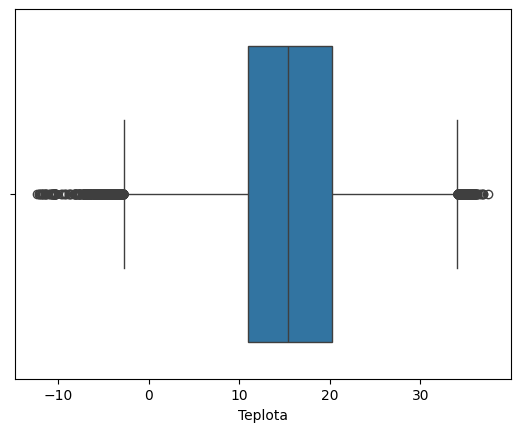

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.boxplot(x=dt['Teplota'].astype(float))
plt.show()

/home/pp/program/jupyter/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 22.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


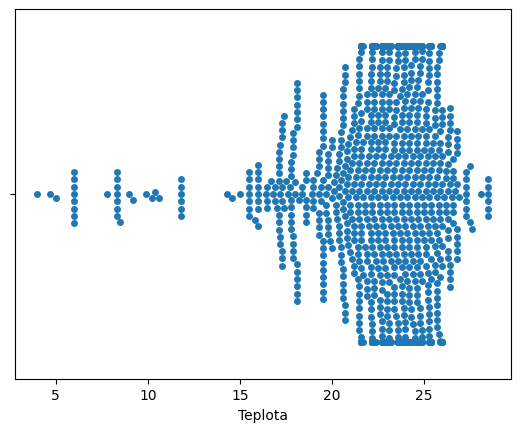

In [27]:
sns.swarmplot(x=dt['Teplota'].astype(float).head(1000))
plt.show()

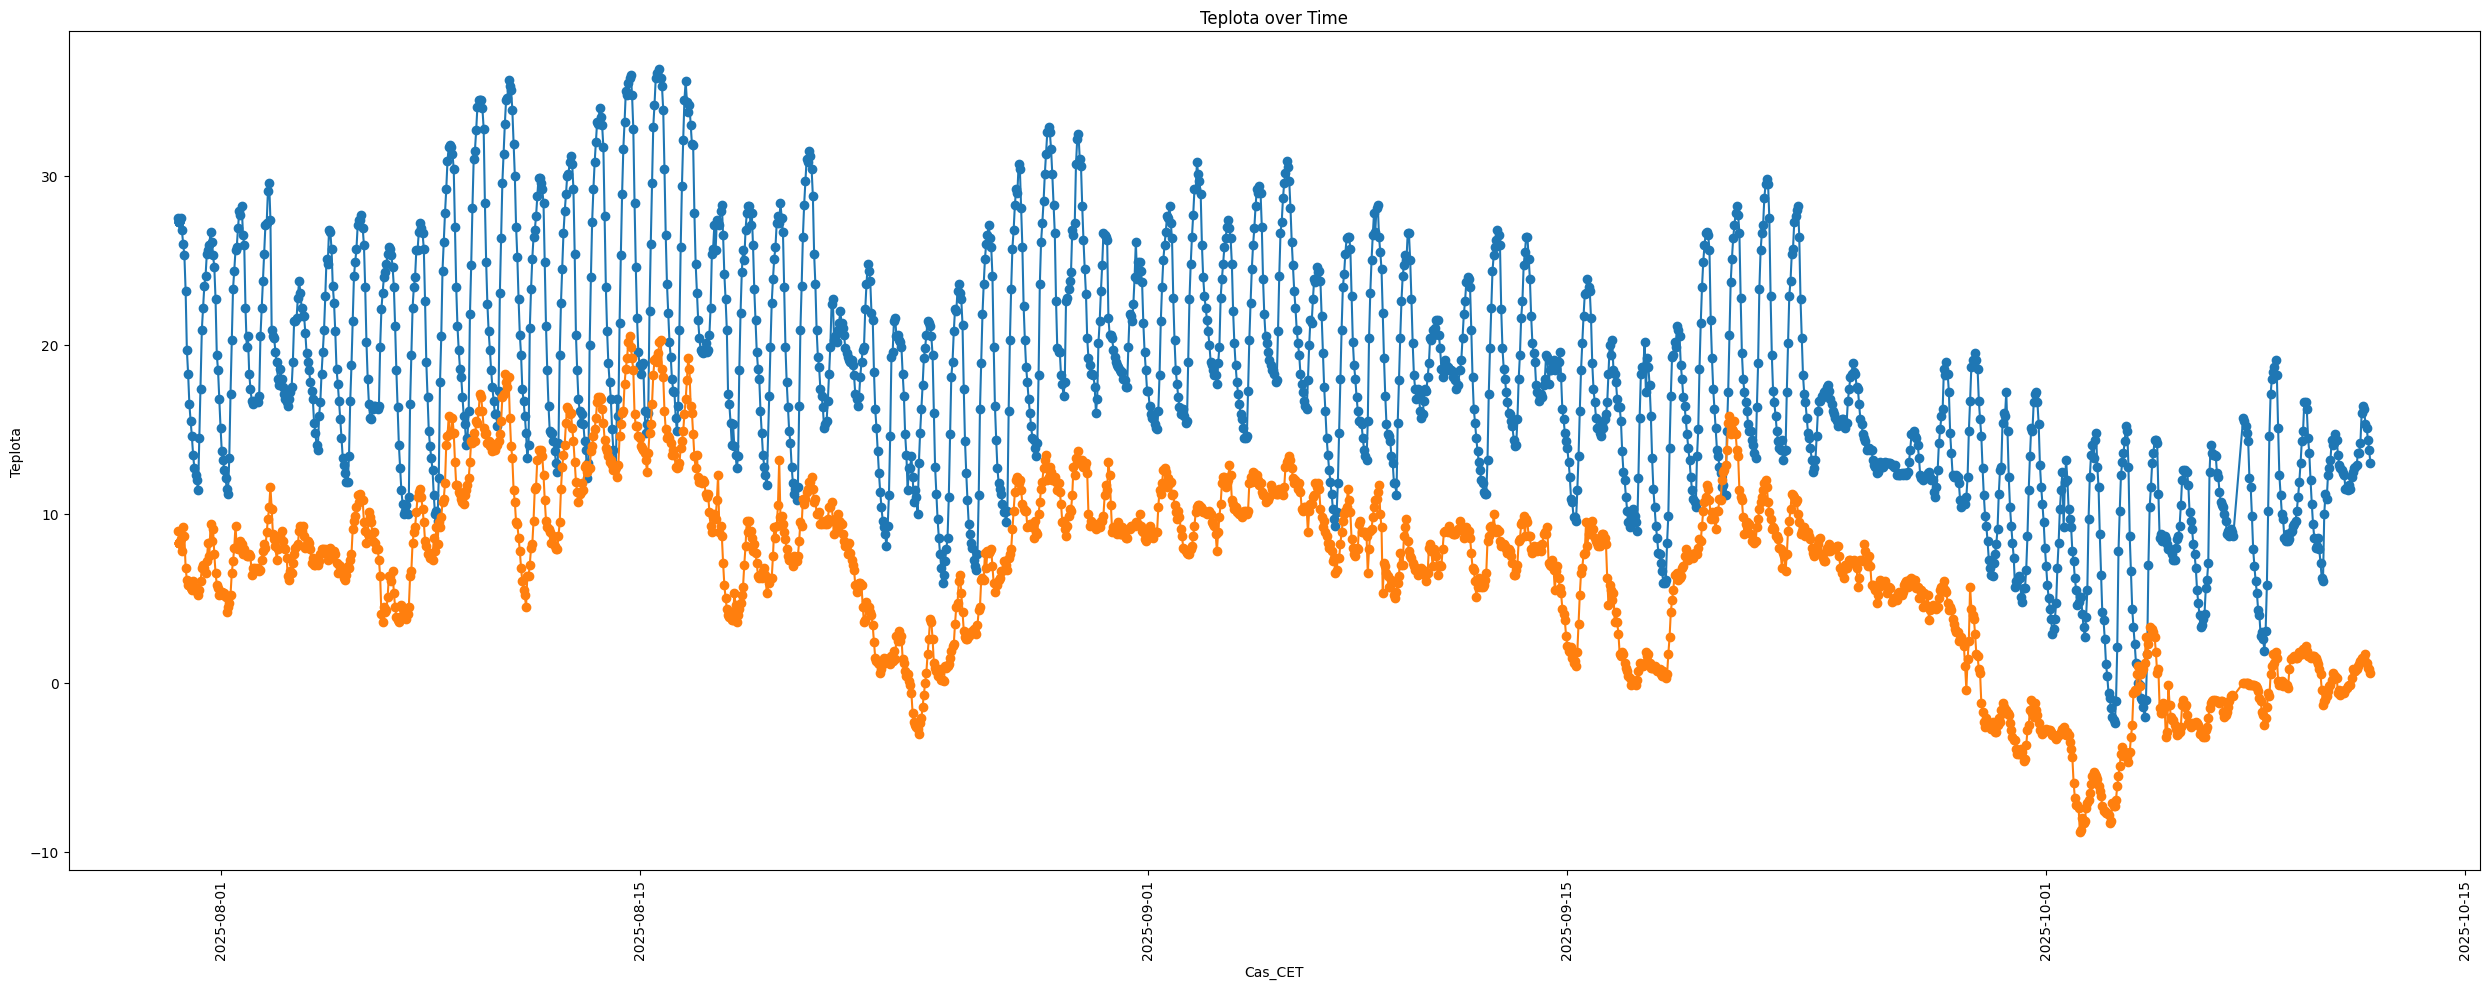

In [28]:
dta=df.loc[['Dudince', 'Žilina','Chopok'],['Teplota','Cas_CET']]
dta=df.loc[['Dudince', 'Chopok'],['Teplota','Cas_CET']]

plt.figure(figsize=(25, 10))
data=dta.loc[['Dudince'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET'], data['Teplota'],marker='o', linestyle='-')
data=dta.loc[['Chopok'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET'], data['Teplota'],marker='o', linestyle='-')
plt.xlabel('Cas_CET')
plt.ylabel('Teplota')
plt.title('Teplota over Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.size=(150, 10)
plt.show()

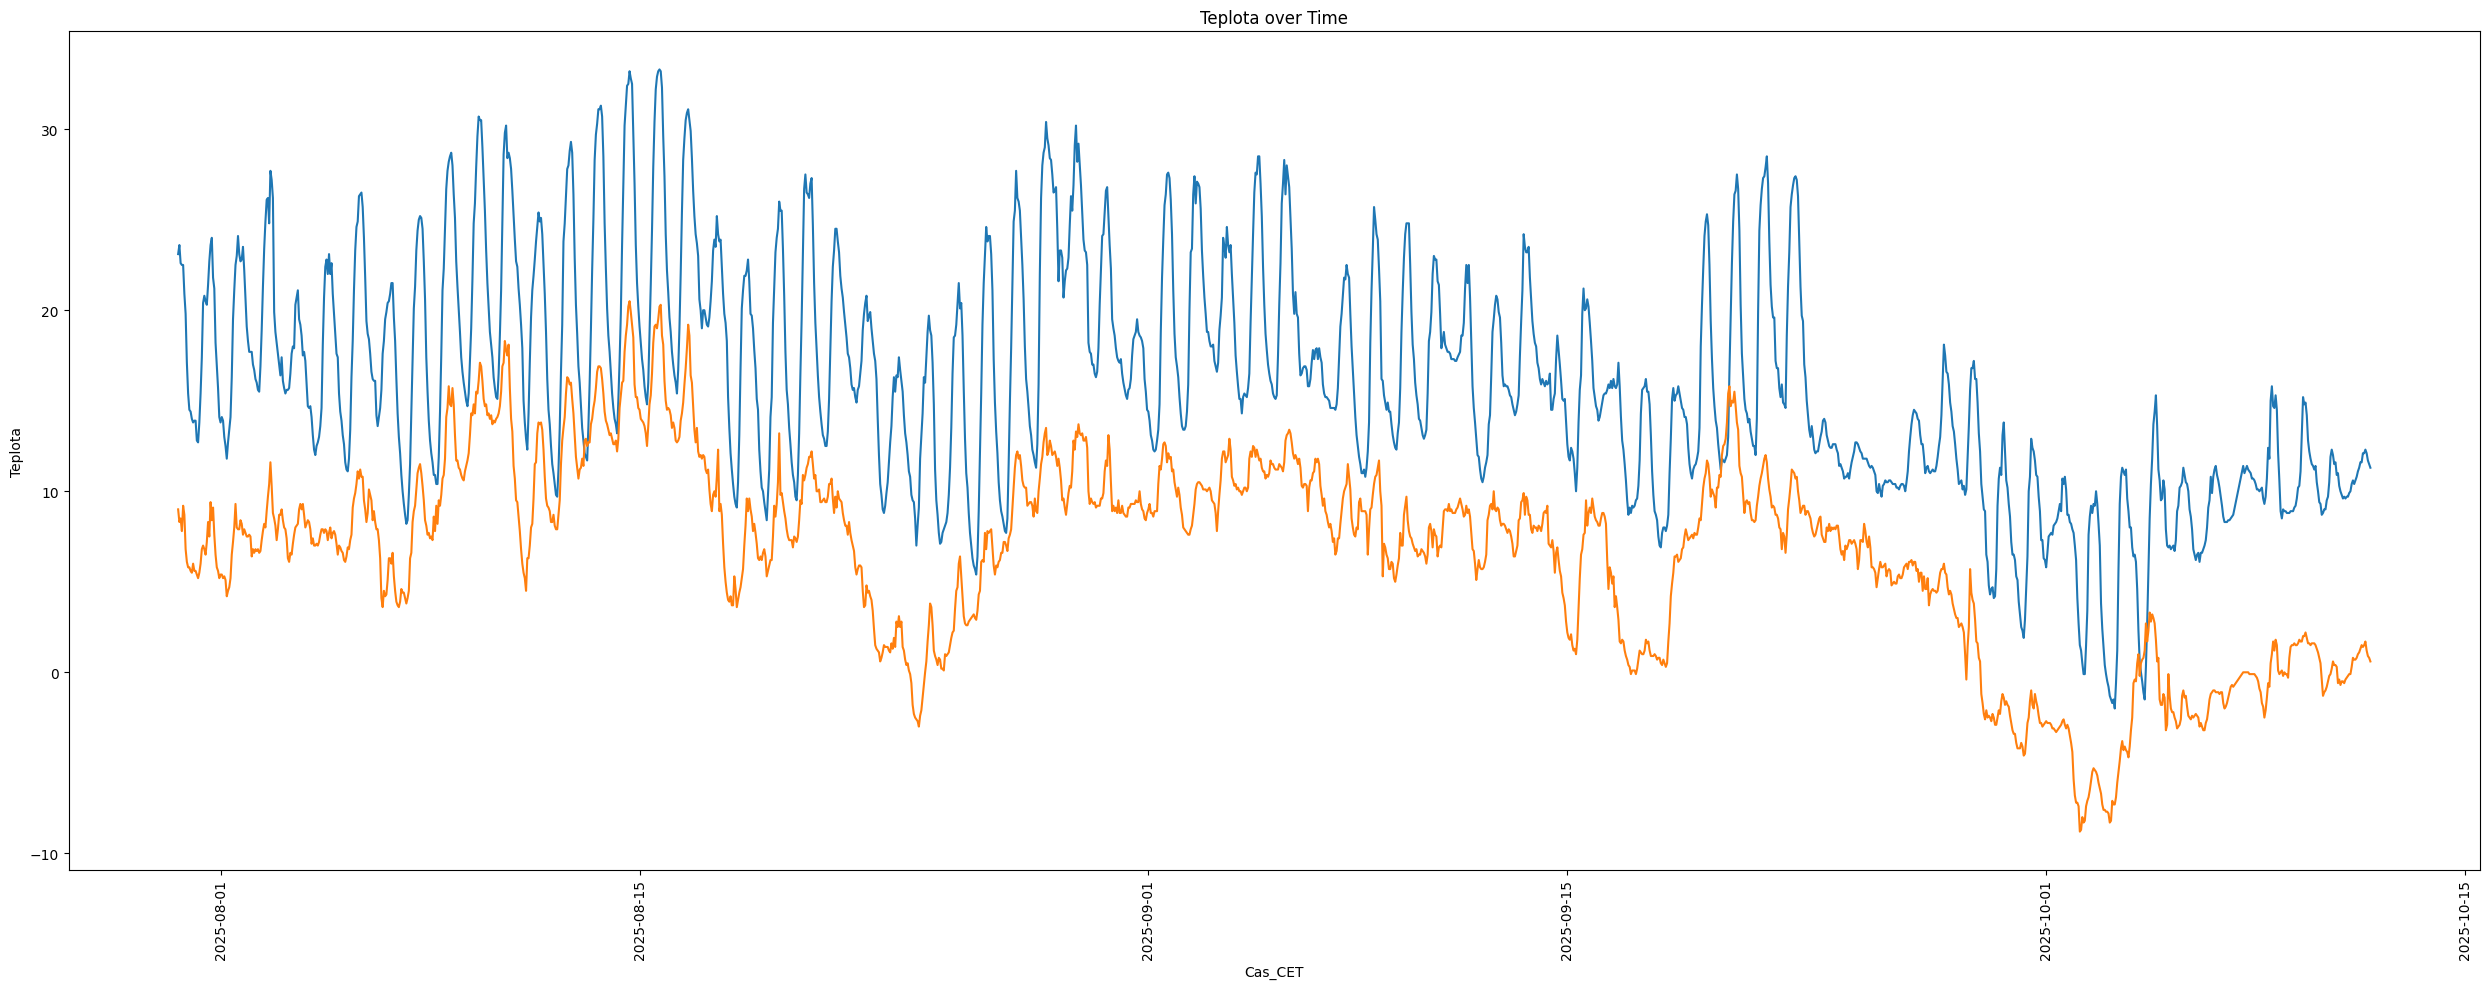

In [29]:
# dta=df.loc[['Dudince', 'Žilina','Chopok'],['Teplota','Cas_CET']]
# dta=df.loc[['Dudince', 'Chopok'],['Teplota','Cas_CET']]

plt.figure(figsize=(25, 10))
data=df.loc[['Žilina'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET'], data['Teplota'],marker='', linestyle='-')
data=df.loc[['Chopok'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET'], data['Teplota'],marker='', linestyle='-')
plt.xlabel('Cas_CET')
plt.ylabel('Teplota')
plt.title('Teplota over Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.size=(150, 10)
plt.show()

In [30]:
# Resample to daily frequency, calculating the mean temperature for each day
df = df.reset_index()
dmi = df.set_index(['Cas_CET']).groupby('Stanica').resample('1D')['Teplota'].mean()
# Calculate a rolling mean with a window of 5 days
dmroll = dmi.rolling(window=5).mean()
# Reset index to turn the MultiIndex into columns
dmroll = dmroll.reset_index().set_index(['Stanica'])
dmi = dmi.reset_index().set_index(['Stanica'])

# For multiple aggregations
dfMultiple = df.set_index(['Cas_CET']).groupby('Stanica').resample('1D').agg({'Teplota': ['mean', 'max', 'min']})
# Reset index to turn the MultiIndex into columns
dfMultiple = dfMultiple.reset_index().set_index(['Stanica'])
print(dfMultiple.head(10))


                            Cas_CET    Teplota            
                                          mean   max   min
Stanica                                                   
Banská Bystrica - Zelená 2025-07-30  21.853333  24.4  15.4
Banská Bystrica - Zelená 2025-07-31  17.645833  23.1  11.2
Banská Bystrica - Zelená 2025-08-01  17.929167  24.0  10.5
Banská Bystrica - Zelená 2025-08-02  19.145833  26.0  15.2
Banská Bystrica - Zelená 2025-08-03  18.116667  22.0  15.1
Banská Bystrica - Zelená 2025-08-04  19.341667  24.4  16.3
Banská Bystrica - Zelená 2025-08-05  18.845833  25.5  12.3
Banská Bystrica - Zelená 2025-08-06  17.700000  22.1  12.6
Banská Bystrica - Zelená 2025-08-07  16.008333  24.3   7.8
Banská Bystrica - Zelená 2025-08-08  18.739130  28.7   9.3


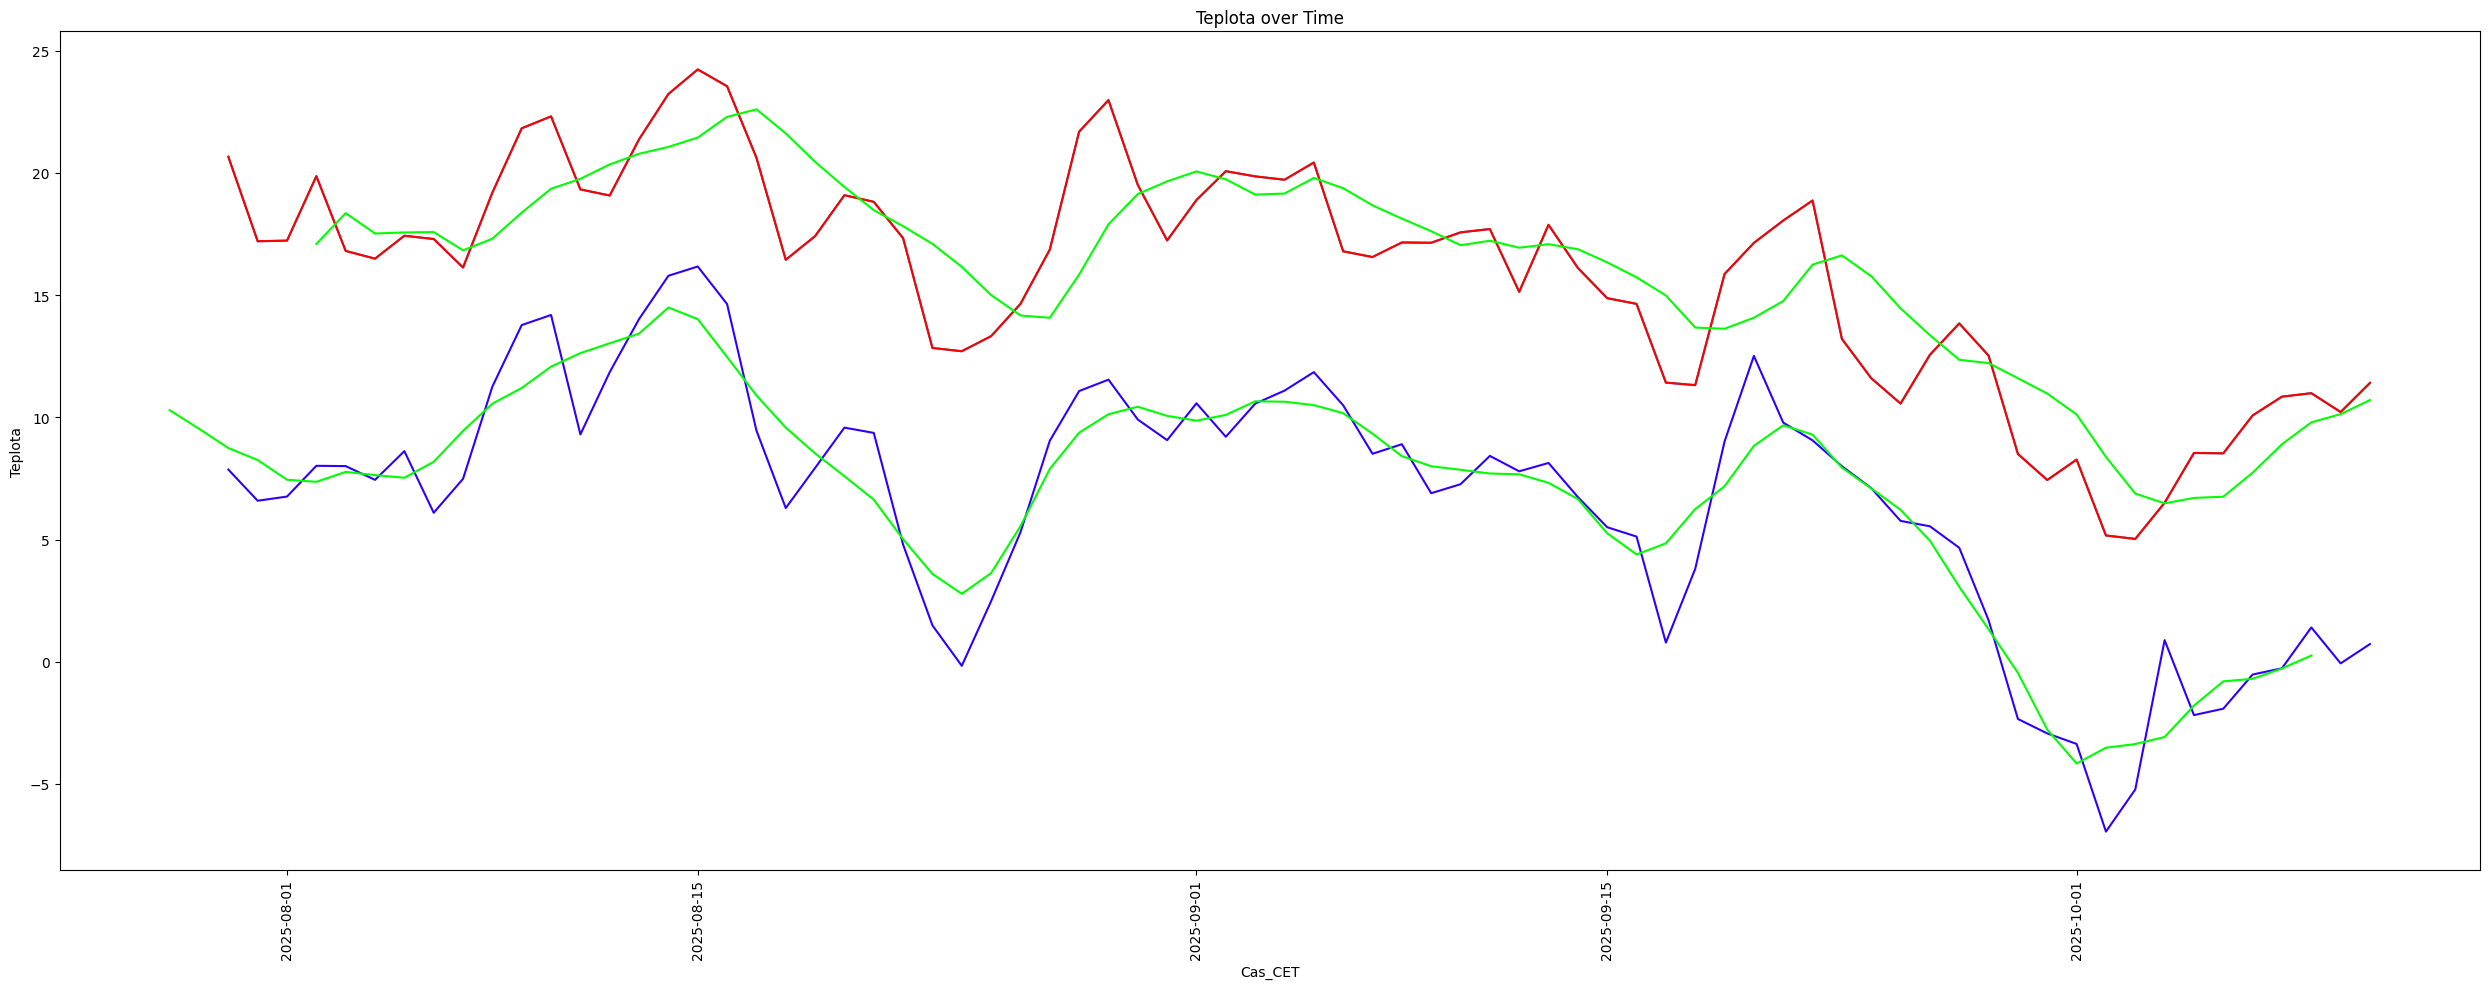

In [ ]:




df = dmi.reset_index()
plt.figure(figsize=(25, 10))
data=df.loc[['Žilina - letisko'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET'], data['Teplota'],marker='', linestyle='-')
data=dmi.loc[['Žilina - letisko'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET'], data['Teplota'],marker='', color='#FF0000', linestyle='-')
data=dmroll.loc[['Žilina - letisko'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET']  - pd.DateOffset(days=0), data['Teplota'],marker='', color='#00FF00', linestyle='-')


data=df.loc[['Chopok'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET'] , data['Teplota'],marker='', color="#2F00FF", linestyle='-')

data=dmroll.loc[['Chopok'],:].sort_values(by=['Cas_CET'])
plt.plot(data['Cas_CET']  - pd.DateOffset(days=2), data['Teplota'],marker='', color='#00FF00', linestyle='-')

plt.xlabel('Cas_CET')
plt.ylabel('Teplota')
plt.title('Teplota over Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.size=(150, 10)
plt.show()



In [36]:
dmi = df.set_index(['Cas_CET'], drop = False).groupby('Stanica').resample('1ME')['Teplota'].mean()
dmi.info()
dmi=dmi.reset_index()
dmi=dmi.set_index('Stanica')
dmi.info()
df.index
dmi.index
dmi.loc[['Žilina - letisko']]


<class 'pandas.core.series.Series'>
MultiIndex: 421 entries, ('Banská Bystrica - Zelená', Timestamp('2025-07-31 00:00:00')) to ('Žilina - letisko', Timestamp('2025-10-31 00:00:00'))
Series name: Teplota
Non-Null Count  Dtype  
--------------  -----  
421 non-null    float64
dtypes: float64(1)
memory usage: 9.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 421 entries, Banská Bystrica - Zelená to Žilina - letisko
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Cas_CET  421 non-null    datetime64[us]
 1   Teplota  421 non-null    float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 9.9+ KB


,Cas_CET,Teplota
Stanica,,
Žilina - letisko,2025-07-31,18.932083
Žilina - letisko,2025-08-31,18.608403
Žilina - letisko,2025-09-30,15.446999
Žilina - letisko,2025-10-31,8.688220


In [37]:
brezno = df[df['Stanica'] == 'Brezno']
dfbr = brezno.set_index(['Cas_CET']).resample('D').Teplota.agg(['min', 'max', 'mean', 'median' ])
dfbr.reset_index(inplace=True)
dfbr['Cas_CET'] = dfbr['Cas_CET'].dt.strftime('%Y-%m-%d')
dfbr.info()
dfbr


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Cas_CET  74 non-null     object 
 1   min      74 non-null     float64
 2   max      74 non-null     float64
 3   mean     74 non-null     float64
 4   median   74 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.0+ KB


,Cas_CET,min,max,mean,median
0,2025-07-30,22.326667,22.326667,22.326667,22.326667
1,2025-07-31,16.954167,16.954167,16.954167,16.954167
2,2025-08-01,16.820833,16.820833,16.820833,16.820833
3,2025-08-02,17.791667,17.791667,17.791667,17.791667
4,2025-08-03,17.991667,17.991667,17.991667,17.991667
...,...,...,...,...,...
69,2025-10-07,9.017647,9.017647,9.017647,9.017647
70,2025-10-08,8.387500,8.387500,8.387500,8.387500
71,2025-10-09,10.016667,10.016667,10.016667,10.016667
72,2025-10-10,9.187500,9.187500,9.187500,9.187500


In [38]:
br = brezno[brezno['Cas_CET'] < '2025-08-01']
br = br.loc[:,['Cas_CET','Teplota']]
br['Datum'] = br['Cas_CET'].dt.strftime('%Y-%m-%d')
# br['Cas_CET'].strftime('%Y-%m-d%')
# seria = br['Cas_CET'].copy()
# seria.info()
# br['Datum'] = seria.dt.strftime('%Y-%m-%d')
br


,Cas_CET,Teplota,Datum
634,2025-07-30,22.326667,2025-07-30
635,2025-07-31,16.954167,2025-07-31
